In [31]:
import time
import typing

import tqdm
import torch
import wandb
import random
import pandas
import torchvision
import sklearn.metrics
import matplotlib.pyplot as plt
import torch.utils.data as torchdata

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

RANDOM_STATE = 42
def set_random_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
def fix_random():
    return set_random_seed(RANDOM_STATE)
fix_random()

mps


In [32]:
wandb.login(anonymous = "allow")

True

# 1. Train the CNN based classifier

## Load the dataset


In [33]:
fix_random()

# Transforms
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean = torch.tensor([ 0.491, 0.482, 0.447 ]),
        std = torch.tensor([ 0.247, 0.244, 0.262 ])
    )
])

# Load dataset
train_set = torchvision.datasets.CIFAR10('cifar-10', train = True, download = True, transform = transforms)
test_set = torchvision.datasets.CIFAR10('cifar-10', train = False, download = True, transform = transforms)

# Split dataset into train and val
train_set, val_set = torchdata.random_split(train_set, [ len(train_set) - 5000, 5000 ])

# Extract labels
labels = test_set.classes

# Check
print(len(train_set), len(val_set), len(test_set))

Files already downloaded and verified
Files already downloaded and verified
45000 5000 10000


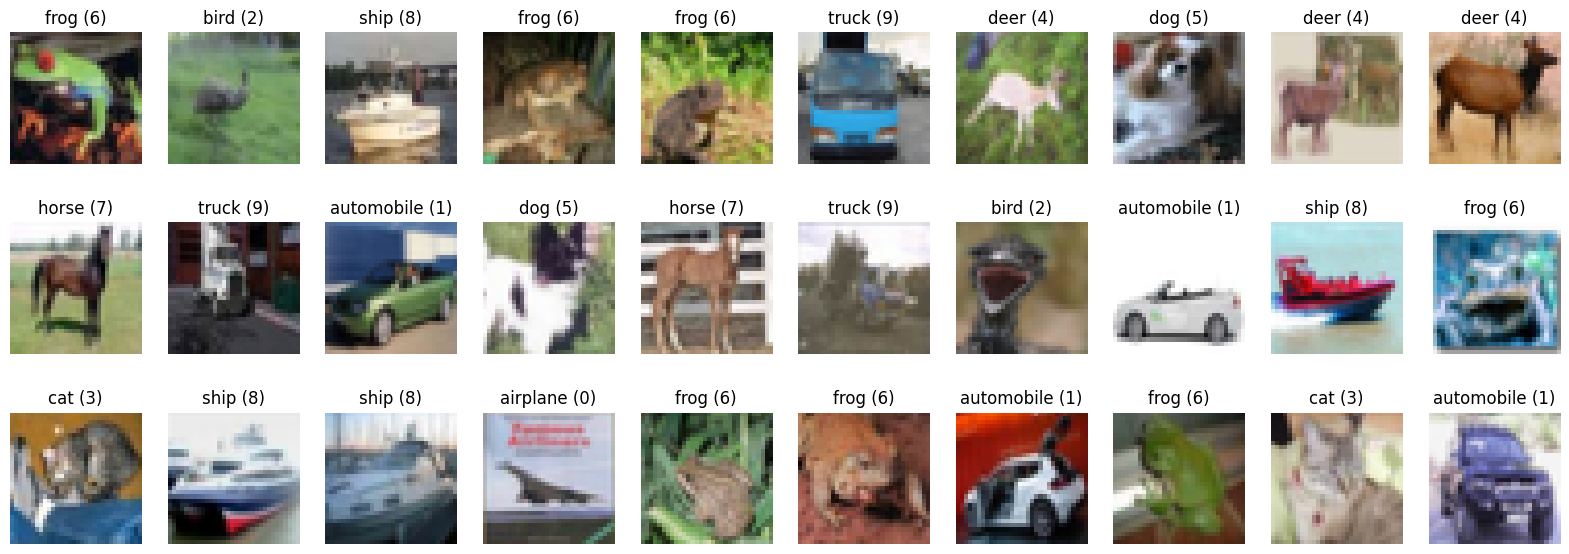

In [34]:
# Denormalization
denormalize = torchvision.transforms.Compose([
    torchvision.transforms.Normalize(
        mean = [ 0., 0., 0. ],
        std = 1 / transforms.transforms[1].std
    ),
    torchvision.transforms.Normalize(
        mean = -transforms.transforms[1].mean,
        std = [ 1., 1., 1. ]
    )
])

# Display some samples
for i in range(10):
    image, class_num = train_set[i]
    plt.subplot(3, 10, i + 1)
    plt.axis('off')
    plt.imshow(denormalize(image).permute(1, 2, 0))
    plt.title('{} ({})'.format(labels[class_num], str(class_num)))

for i in range(10):
    image, class_num = val_set[i]
    plt.subplot(3, 10, i + 11)
    plt.axis('off')
    plt.imshow(denormalize(image).permute(1, 2, 0))
    plt.title('{} ({})'.format(labels[class_num], str(class_num)))

for i in range(10):
    image, class_num = test_set[i]
    plt.subplot(3, 10, i + 21)
    plt.axis('off')
    plt.imshow(denormalize(image).permute(1, 2, 0))
    plt.title('{} ({})'.format(labels[class_num], str(class_num)))

## Function for accuracy checking

In [42]:
import numpy
def calc_metrics(model, dataset = val_set) -> dict:
    loader = torchdata.DataLoader(dataset, batch_size = 256, shuffle = False)
    model.model.eval() # Enter evaluation mode
    model = model.model.to(device) # To GPU
    with torch.no_grad():
        y_predicted = numpy.array([])
        y_true = numpy.array([])
        scores = numpy.empty((0, 10))
        for images, labels in loader:
            # To GPU
            images = images.to(device)
            labels = labels.to(device)

            # Get predictions
            outputs = torch.nn.Softmax(dim = 1)(model(images))
            predicted = torch.argmax(outputs, dim = 1)

            # Store predictions
            y_predicted = numpy.append(y_predicted, predicted.cpu().detach().numpy())
            y_true = numpy.append(y_true, labels.cpu().detach().numpy())
            scores = numpy.concatenate([ scores, outputs.cpu().detach().numpy() ])

    return {
        'Accuracy': sklearn.metrics.accuracy_score(y_true, y_predicted),
        'TOP-2 Accuracy': sklearn.metrics.top_k_accuracy_score(y_true, scores, k = 2),
        'TOP-3 Accuracy': sklearn.metrics.top_k_accuracy_score(y_true, scores, k = 3),
        'TOP-4 Accuracy': sklearn.metrics.top_k_accuracy_score(y_true, scores, k = 4),
        'TOP-5 Accuracy': sklearn.metrics.top_k_accuracy_score(y_true, scores, k = 5),
        'TOP-6 Accuracy': sklearn.metrics.top_k_accuracy_score(y_true, scores, k = 6),
        'TOP-7 Accuracy': sklearn.metrics.top_k_accuracy_score(y_true, scores, k = 7),
        'TOP-8 Accuracy': sklearn.metrics.top_k_accuracy_score(y_true, scores, k = 8),
        'TOP-9 Accuracy': sklearn.metrics.top_k_accuracy_score(y_true, scores, k = 9),
        'AUC-ROC': sklearn.metrics.roc_auc_score(y_true, scores, multi_class = 'ovo'),
        'Precision': sklearn.metrics.precision_score(y_true, y_predicted, average = 'macro'),
        'Recall': sklearn.metrics.recall_score(y_true, y_predicted, average = 'macro'),
        'F1-score': sklearn.metrics.f1_score(y_true, y_predicted, average = 'macro')
    }

## Implement CNN class for CIFAR10

**In constructor**

Define 2 - 3 convolutional layers

 https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

with corresponding in/out dimensions W_out = 1 + ((W_in - F + 2*P) / S)


Also define max pooling : https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

and fully connected layers: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear


**In forward**

Write code for forward pass.
Remember that first dimension is the batch dimension

In [43]:
class TorchModel:
    def __init__(
            self,
            name: str,
            model: torch.nn.Module,
            batch_size: int = 256,
            device: torch.device = device,
            metrics: typing.Callable = calc_metrics,
            optimizer: typing.Optional[torch.optim.Optimizer] = None,
            scheduler: typing.Optional[torch.optim.lr_scheduler.LRScheduler] = None,
        ):
        self.name = name
        self.history = [ ]
        self.device = device
        self.metrics = metrics
        self.scheduler = scheduler
        self.batch_size = batch_size
        self.loss = torch.nn.CrossEntropyLoss()
        self.model = model.to(self.device)
        self.optimizer = optimizer or torch.optim.AdamW(model.parameters())

    def train(self, images: torch.Tensor, labels: torch.Tensor) -> float:
        images = images.to(self.device) # To GPU
        labels = labels.to(self.device) # To GPU
        self.optimizer.zero_grad() # Zero gradients
        output = self.model(images) # Get predictions
        loss = self.loss(output, labels) # Calculate loss
        loss.backward() # Calculate gradients
        self.optimizer.step() # Update weights
        return loss.item()

    def train_epoch(self, loader: torchdata.DataLoader) -> float:
        for images, labels in loader:
            loss = self.train(images, labels)
        if self.scheduler is not None:
            self.scheduler.step()
        return loss
       
    def fit(self, dataset: torchdata.Dataset, n_epochs: int = 1):
        loader = torchdata.DataLoader(dataset, batch_size = self.batch_size, shuffle = True)
        wandb.init(project = "CV-HW-4", name = self.name, anonymous = "allow")
        wandb.watch(self.model, log = "all")
        for epoch in tqdm.trange(n_epochs):
            self.model.train() # Enter train mode
            train_start = time.perf_counter()
            loss = self.train_epoch(loader)
            train_time = time.perf_counter() - train_start
            metrics = { 'Loss': loss, 'Train time': train_time }

            self.model.eval() # Enter evaluation mode
            val_start = time.perf_counter()
            with torch.no_grad():
                metrics.update(self.metrics(self))
            val_time = time.perf_counter() - val_start
            metrics['Validation time'] = val_time
            
            wandb.log(metrics)
            self.history.append(metrics)

        wandb.finish()
        return self
    
    def predict(self, X: numpy.ndarray) -> numpy.ndarray:
        self.model.eval()
        with torch.no_grad():
            X = self.preprocess(X)
            y = self.model(X.to(self.device))
            return self.postprocess(y)

fix_random()
TorchModel(name = 'test', model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(3072, 10)
)).fit(train_set, 1)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


100%|██████████| 1/1 [00:05<00:00,  5.18s/it]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AUC-ROC,▁
Accuracy,▁
F1-score,▁
Loss,▁
Precision,▁
Recall,▁
TOP-2 Accuracy,▁
TOP-3 Accuracy,▁
TOP-4 Accuracy,▁
TOP-5 Accuracy,▁
TOP-6 Accuracy,▁


In [ ]:
import torch.nn as nn
nn.Conv2d?

In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class TwoLayerCNN(nn.Module):

    def __init__(self, class_nums = 10):
        super().__init__()

        # Put your code here ...

    def forward(self, batch):

        # Put your code here ...

        return scores


## Train the model




## First Activate tensorboard extension

Use summaryWriter to create logs: https://pytorch.org/docs/stable/tensorboard.html?highlight=summarywriter#torch.utils.tensorboard.writer.SummaryWriter

Display loss and accuracy charts.

You can cange log dir name.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

### Implement training loop

- Create optimizer,
- Save loss and accuracy values into tensorboard log
- Use GPU to speedup training process.


In [ ]:
import torch.optim as optim
import torchvision
import os
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TwoLayerCNN(10)
"""
  Send model to GPU
"""
model.train()

criterion = nn.CrossEntropyLoss()

"""
  Setup optimizer for your model
"""

for epoch in range(15):
  for step, (img_batch, labels_batch) in enumerate(train_loader):
    output = model(img_batch)
    loss = criterion(output, labels_batch)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  accuracy = validate(model,val_loader, device)
  """
    Write data to tensorboard logs
  """

  # You can remove this line when the Tensorboard starts working
  print("Epoch {} Loss {:.2f} Accuracy {:.2f}".format(epoch,loss.item(),accuracy))


### Validat results on test dataset

You must get accuracy above 0.65

In [ ]:
test_dataset = datasets.CIFAR10("content",
                           train=False,
                           transform = dataset.transform, # Transforms stay the same
                           download=True)

test_loader = DataLoader(test_dataset, batch_size = batch_size)

accuracy = validate(model,test_loader,device)
print(f"Accuracy on test:{accuracy}")


# 2. Compare different Normalization methods

* Add extra conv layer to your model (3-7)
* Take three different normalization layers: BatchNorm, InstanceNorm, LayerNorm
* Train the model with each of them.
* Plot the loss curve for different normalization in same axis


*Because this task is time consuming it is recommended to perform calculations on a small piece of datastat*

In [ ]:
# Put your code here ...

# Place for brief conclusion:

....


# Ideas for extra work

---
1. Evaluate the impact of the number and size of filters in convolutional layers on the accuracy.

2. Evaluate the impact of the convolutional layers count on the accuracy.

3. Visualize something: filters, activations ...

---







